## 00. Imports:

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from xgboost import XGBClassifier
import lightgbm as lgb
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D, Dense, Dropout
from sklearn.metrics import accuracy_score
from sklearn.utils import class_weight


## 01. Loading MEFAR PreProcessed DataSet and Setting X & Y Variables:

In [3]:
MEFAR_MID = pd.read_csv('../raw_data//MEFAR_preprocessed/MEFAR_MID.csv')


In [4]:
MEFAR_MID.shape

(923298, 18)

In [5]:
X_all = MEFAR_MID.drop(columns=['class'])
y_all = MEFAR_MID['class']

In [6]:
X_EEG = X_all.drop(['BVP', 'EDA', 'TEMP', 'AccX', 'AccY', 'AccZ', 'HR'], axis=1)

In [7]:
X_EEG.shape, y_all.shape

((923298, 10), (923298,))

In [8]:
X_all.shape, y_all.shape

((923298, 17), (923298,))

In [9]:
X_all.head()

,BVP,EDA,TEMP,AccX,AccY,AccZ,HR,Delta,Theta,Alpha1,Alpha2,Beta1,Beta2,Gamma1,Gamma2,Attention,Meditation
0,-0.150426,0.026215,0.778824,-0.325490,0.019608,0.388235,0.357959,0.019138,0.082949,0.017362,0.020516,0.001465,0.002844,0.021253,0.044376,0.484848,0.090909
1,-0.145506,0.026215,0.778824,-0.333333,-0.003922,0.388235,0.357959,0.019138,0.082949,0.017362,0.020516,0.001465,0.002844,0.021253,0.044376,0.484848,0.090909
2,-0.135576,0.026215,0.778824,-0.349020,-0.035294,0.333333,0.357959,0.019138,0.082949,0.017362,0.020516,0.001465,0.002844,0.021253,0.044376,0.484848,0.090909
3,-0.121047,0.026215,0.778824,-0.380392,-0.027451,0.356863,0.357959,0.019138,0.082949,0.017362,0.020516,0.001465,0.002844,0.021253,0.044376,0.484848,0.090909
4,-0.103369,0.026215,0.778824,-0.411765,-0.011765,0.411765,0.357959,0.019138,0.082949,0.017362,0.020516,0.001465,0.002844,0.021253,0.044376,0.484848,0.090909


In [10]:
X_EEG.head()

,Delta,Theta,Alpha1,Alpha2,Beta1,Beta2,Gamma1,Gamma2,Attention,Meditation
0,0.019138,0.082949,0.017362,0.020516,0.001465,0.002844,0.021253,0.044376,0.484848,0.090909
1,0.019138,0.082949,0.017362,0.020516,0.001465,0.002844,0.021253,0.044376,0.484848,0.090909
2,0.019138,0.082949,0.017362,0.020516,0.001465,0.002844,0.021253,0.044376,0.484848,0.090909
3,0.019138,0.082949,0.017362,0.020516,0.001465,0.002844,0.021253,0.044376,0.484848,0.090909
4,0.019138,0.082949,0.017362,0.020516,0.001465,0.002844,0.021253,0.044376,0.484848,0.090909


## 02. Creating Time-Window Data & Train-Test Split:

In [11]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

sampling_rate = 32
window_seconds = 10  # 10 seconds of data = 320 rows
window_size = sampling_rate * window_seconds
stride = int(window_size * 0.5)  # 50% overlap = 5s shift


In [12]:
session_map = pd.read_csv('../raw_data/MEFAR_preprocessed/Session_Map.csv')
session_map.head()

,session_id,start_index,end_index
0,sub01_morning,0,1777
1,sub01_evening,1777,3679
2,sub02_morning,3679,5635
3,sub02_evening,5635,7593
4,sub03_morning,7593,9550


In [13]:
# Define sampling and windowing parameters
sampling_rate = 32                     # MEFAR data has 32 samples per second
window_seconds = 10                    # Each window covers 10 seconds
window_size = sampling_rate * window_seconds  # 320 samples per window
stride = int(window_size * 0.5)        # 50% overlap between windows → 5s step

# Lists to store results
X_windows, y_windows, session_ids = [], [], []

# Loop through each session defined in session_map
for _, row in session_map.iterrows():
    session_id = row['session_id']               # Session identifier
    start = int(row['start_index'])              # Start index of session in full dataset
    end = int(row['end_index'])                  # End index of session

    # Extract the features and labels for this session
    X_session = X_all.iloc[start:end].values         # Shape: (session_length, num_features)
    y_session = y_all.iloc[start:end].values         # Shape: (session_length,)

    # Slide window through session using defined stride
    for i in range(0, len(X_session) - window_size + 1, stride):
        # Extract the feature window and corresponding label window
        window = X_session[i:i + window_size]          # Shape: (320, num_features)
        label_window = y_session[i:i + window_size]    # Shape: (320,)

        # ✅ Assign label based on majority vote in the 10s window
        # If more than 50% of samples in the window are "1" (fatigued), label the window as fatigued
        majority_label = int(label_window.mean() > 0.5)

        # Store results
        X_windows.append(window)
        y_windows.append(majority_label)
        session_ids.append(session_id)

# Convert lists to numpy arrays for modeling
X_windows = np.array(X_windows)       # Shape: (num_windows, 320, num_features)
y_windows = np.array(y_windows)       # Shape: (num_windows,)
session_ids = np.array(session_ids)   # Shape: (num_windows,)

# # Optional: Normalize each window individually using min-max scaling
# # This ensures each feature in each window is scaled to [0, 1] based on its own min/max
# X_norm = np.array([MinMaxScaler().fit_transform(window) for window in X_windows])

In [14]:
X_all.shape[1]

17

In [15]:
X_windows.shape

(501, 320, 17)

In [16]:
# Create train-test split (e.g., 80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X_windows, y_windows,
    test_size=0.2,
    random_state=42,
    stratify=y_windows  # ensures same class distribution in train and test
)

In [17]:
X_train.shape

(400, 320, 17)

In [18]:
X_test.shape

(101, 320, 17)

In [19]:
y_train.shape

(400,)

## 03. LSTM (Long Short-Term Memory) - ALL FEATURES:

In [20]:
# MODEL VERSION 001
model = Sequential([
    # LSTM layer with 64 units, processing sequences of shape (320 timesteps, 17 features)
    LSTM(64, input_shape=(320, 17), return_sequences=False),
    # Dropout to prevent overfitting by randomly deactivating 30% of units
    Dropout(0.3),
    # Dense hidden layer with 32 neurons and ReLU activation
    Dense(32, activation='relu'),
    Dropout(0.3),
    # Another dropout layer for regularization
    Dense(1, activation='sigmoid') # 1 neuron and sigmoid activation function for binary classification.
])

# Compile model & Fit:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Evaluation
y_pred = (model.predict(X_test) > 0.5).astype(int)
print(classification_report(y_test, y_pred))

Epoch 1/10


/Users/timoturnley/.pyenv/versions/3.10.6/envs/Neurocheck/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.7220 - loss: 0.6441 - val_accuracy: 0.8500 - val_loss: 0.4600
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.8499 - loss: 0.4332 - val_accuracy: 0.9750 - val_loss: 0.1717
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9961 - loss: 0.1468 - val_accuracy: 0.9750 - val_loss: 0.0866
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9887 - loss: 0.0656 - val_accuracy: 0.9750 - val_loss: 0.0882
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9945 - loss: 0.0407 - val_accuracy: 0.9750 - val_loss: 0.0878
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9765 - loss: 0.0729 - val_accuracy: 0.9750 - val_loss: 0.0653
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9945 - loss: 0.0347 - val_accuracy: 0.9750 - val_loss: 0.0642
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9948 - loss: 0.0311 - val_accuracy: 0.9750 - val_loss: 0.

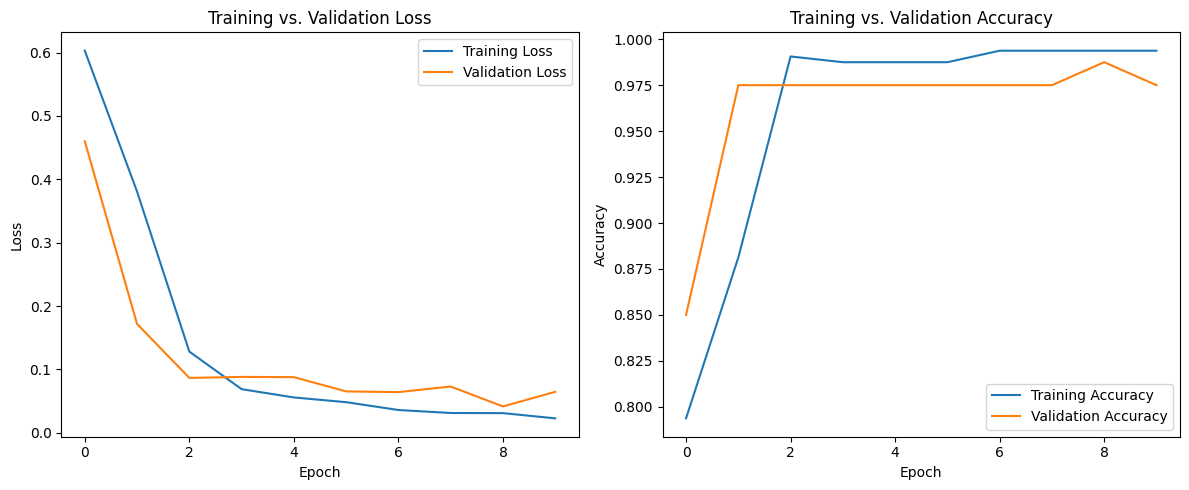

In [21]:
# Extract training history
history_dict = history.history

# Plot training & validation loss
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history_dict['loss'], label='Training Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs. Validation Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history_dict['accuracy'], label='Training Accuracy')
plt.plot(history_dict['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs. Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

* **Left-Loss Curve** - training and validation loss decrease steadily this is a good sign. 
* **Right-Accuracy Curve** - Both training and validation accuracy quickly climb to 99%. 
* *To Improve* - Add Early stopping

In [22]:
# MODEL VERSION 002
# Early stopping to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


model2 = Sequential([
    # LSTM layer with 32 units, processing sequences of shape (320 timesteps, 17 features)
    LSTM(32, input_shape=(320, 17), return_sequences=False),
    # Dropout to prevent overfitting by randomly deactivating 30% of units
    Dropout(0.3),
    # Dense hidden layer with 32 neurons and ReLU activation
    Dense(16, activation='relu'),
    Dropout(0.3),
    # Another dropout layer for regularization
    Dense(1, activation='sigmoid') # 1 neuron and sigmoid activation function for binary classification.
])

# Compile model & Fit:
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history2 = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2,callbacks=[early_stop])


Epoch 1/10
 5/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 1.0000 - loss: 0.0059

/Users/timoturnley/.pyenv/versions/3.10.6/envs/Neurocheck/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9962 - loss: 0.0159 - val_accuracy: 0.9875 - val_loss: 0.0377
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9899 - loss: 0.0203 - val_accuracy: 0.9750 - val_loss: 0.0675
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9859 - loss: 0.0338 - val_accuracy: 0.9875 - val_loss: 0.0389
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9938 - loss: 0.0359 - val_accuracy: 0.9750 - val_loss: 0.1474


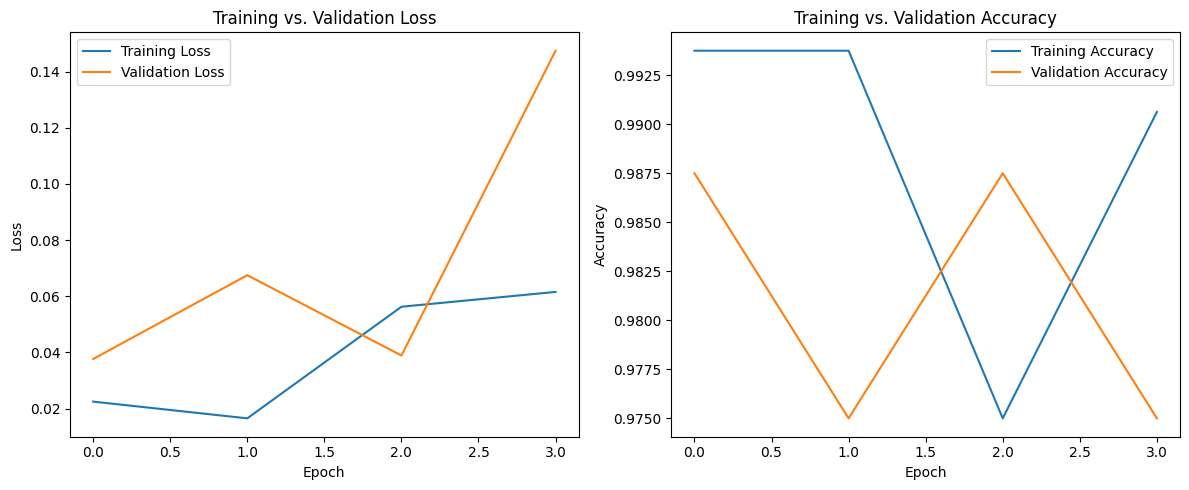

In [23]:
# Extract training history
history_dict2 = history2.history

# Plot training & validation loss
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history_dict2['loss'], label='Training Loss')
plt.plot(history_dict2['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs. Validation Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history_dict2['accuracy'], label='Training Accuracy')
plt.plot(history_dict2['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs. Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

* **Training-Validation Accuracy Right** - both curves rapidly reach 100% accuracy within 2-3 epochs
* **Training-Validation Loss Left** - Both losses drop sharply and stabilize near zero. 

In [24]:
# Evaluation
y_pred2 = (model2.predict(X_test) > 0.5).astype(int)
print(classification_report(y_test, y_pred))


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
              precision    recall  f1-score   support

           0       1.00      0.97      0.99        75
           1       0.93      1.00      0.96        26

    accuracy                           0.98       101
   macro avg       0.96      0.99      0.97       101
weighted avg       0.98      0.98      0.98       101



## 04. 1D CNN Model (All Features):

In [25]:
# MODEL VERSION 001
model_CNN = Sequential([
    # Conv layer to detect short-term patterns (5 time steps)
    Conv1D(filters=64, kernel_size=5, activation='relu', input_shape=(320, 17)),
    MaxPooling1D(pool_size=2),  # Downsample

    # Second Conv layer to go deeper
    Conv1D(filters=128, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),

    # Global pooling to reduce each feature map to a single number
    GlobalAveragePooling1D(),

    # Fully connected layer
    Dense(32, activation='relu'),
    Dropout(0.4),

    # Output
    Dense(1, activation='sigmoid')  # Binary classification
])

model_CNN.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

/Users/timoturnley/.pyenv/versions/3.10.6/envs/Neurocheck/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [26]:
history_CNN = model_CNN.fit(X_train, y_train, validation_split=0.2, epochs=10, batch_size=32)

Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5905 - loss: 0.6642 - val_accuracy: 0.8500 - val_loss: 0.4455
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8662 - loss: 0.4123 - val_accuracy: 0.9500 - val_loss: 0.1834
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9679 - loss: 0.1765 - val_accuracy: 1.0000 - val_loss: 0.0490
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9913 - loss: 0.0500 - val_accuracy: 1.0000 - val_loss: 0.0153
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9973 - loss: 0.0187 - val_accuracy: 1.0000 - val_loss: 0.0112
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 0.0091 - val_accuracy: 1.0000 - val_loss: 0.0046
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 0.0059 - val_accuracy: 1.0000 - val_loss: 0.0027
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 0.0049 - val_accuracy: 1.0000 - val_loss

In [27]:
# Predict on test set
y_pred = (model_CNN.predict(X_test) > 0.5).astype(int)

# Classification report
print(classification_report(y_test, y_pred))


1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/stepWARNING:tensorflow:6 out of the last 12 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x312c495a0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        75
           1       1.00      1.00      1.00        26

    accuracy                           1.

In [28]:
# Confusion matrix
print(confusion_matrix(y_test, y_pred))

[[75  0]
 [ 0 26]]


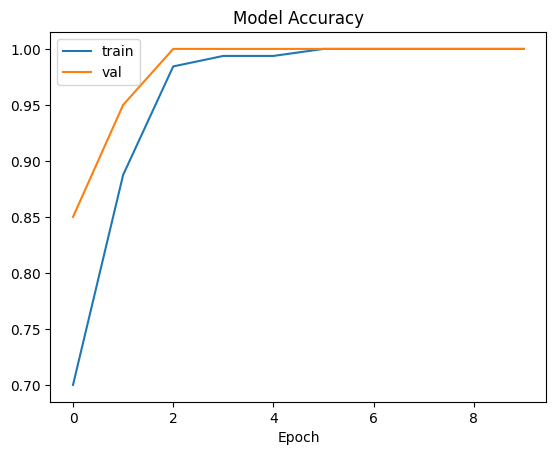

In [29]:
plt.plot(history_CNN.history['accuracy'])
plt.plot(history_CNN.history['val_accuracy'])
plt.legend(['train', 'val'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.show()

## 05. LSTM - EEG Features Only:

In [30]:
# Define sampling and windowing parameters
sampling_rate = 32                     # MEFAR data has 32 samples per second
window_seconds = 10                    # Each window covers 10 seconds
window_size = sampling_rate * window_seconds  # 320 samples per window
stride = int(window_size * 0.5)        # 50% overlap between windows → 5s step

# Lists to store results
X_windows_EEG, y_windows_EEG, session_ids = [], [], []

# Loop through each session defined in session_map
for _, row in session_map.iterrows():
    session_id = row['session_id']               # Session identifier
    start = int(row['start_index'])              # Start index of session in full dataset
    end = int(row['end_index'])                  # End index of session

    # Extract the features and labels for this session
    X_session_EEG = X_EEG.iloc[start:end].values         # Shape: (session_length, num_features)
    y_session_EEG = y_all.iloc[start:end].values         # Shape: (session_length,)

    # Slide window through session using defined stride
    for i in range(0, len(X_session_EEG) - window_size + 1, stride):
        # Extract the feature window and corresponding label window
        window_EEG = X_session_EEG[i:i + window_size]          # Shape: (320, num_features)
        label_window_EEG = y_session_EEG[i:i + window_size]    # Shape: (320,)

        # ✅ Assign label based on majority vote in the 10s window
        # If more than 50% of samples in the window are "1" (fatigued), label the window as fatigued
        majority_label = int(label_window_EEG.mean() > 0.5)

        # Store results
        X_windows_EEG.append(window_EEG)
        y_windows_EEG.append(majority_label)
        session_ids.append(session_id)

# Convert lists to numpy arrays for modeling
X_windows_EEG = np.array(X_windows_EEG)       # Shape: (num_windows, 320, num_features)
y_windows_EEG = np.array(y_windows_EEG)       # Shape: (num_windows,)
session_ids = np.array(session_ids)   # Shape: (num_windows,)

In [31]:
X_windows_EEG.shape, y_windows_EEG.shape

((501, 320, 10), (501,))

In [32]:
# Create train-test split (e.g., 80% train, 20% test)
X_train_EEG, X_test_EEG, y_train_EEG, y_test_EEG = train_test_split(
    X_windows_EEG, y_windows_EEG,
    test_size=0.2,
    random_state=42,
    stratify=y_windows_EEG  # ensures same class distribution in train and test
)

In [33]:
import numpy as np

train_flat = X_train_EEG.reshape(X_train_EEG.shape[0], -1)
test_flat = X_test_EEG.reshape(X_test_EEG.shape[0], -1)

duplicates = np.sum([np.any(np.all(sample == train_flat, axis=1)) for sample in test_flat])
print(f"Duplicate windows in test also seen in train: {duplicates}")

Duplicate windows in test also seen in train: 3


In [34]:
import pandas as pd

flat_X = X_windows_EEG.reshape(X_windows_EEG.shape[0], -1)
df = pd.DataFrame(flat_X)
df['label'] = y_windows_EEG

print(df.groupby('label').std().mean(axis=1))

label
0    0.115908
1    0.110937
dtype: float64


In [35]:
import numpy as np
np.unique(y_windows_EEG, return_counts=True)

(array([0, 1]), array([373, 128]))

In [36]:
# MODEL VERSION 001
# Early stopping to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


model_EEG = Sequential([
    # LSTM layer with 32 units, processing sequences of shape (320 timesteps, 17 features)
    LSTM(32, input_shape=(320, 10), return_sequences=False),
    # Dropout to prevent overfitting by randomly deactivating 30% of units
    Dropout(0.3),
    # Dense hidden layer with 32 neurons and ReLU activation
    Dense(16, activation='relu'),
    Dropout(0.3),
    # Another dropout layer for regularization
    Dense(1, activation='sigmoid') # 1 neuron and sigmoid activation function for binary classification.
])

# Compile model & Fit:
model_EEG.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history_EEG = model_EEG.fit(X_train_EEG, y_train_EEG, epochs=10, batch_size=32, validation_split=0.2,callbacks=[early_stop])

Epoch 1/10


/Users/timoturnley/.pyenv/versions/3.10.6/envs/Neurocheck/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.6728 - loss: 0.6602 - val_accuracy: 0.8000 - val_loss: 0.5780
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7375 - loss: 0.6053 - val_accuracy: 0.8000 - val_loss: 0.5444
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7551 - loss: 0.5795 - val_accuracy: 0.8000 - val_loss: 0.5356
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7339 - loss: 0.5901 - val_accuracy: 0.8000 - val_loss: 0.5342
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7301 - loss: 0.6078 - val_accuracy: 0.8000 - val_loss: 0.5340
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7077 - loss: 0.6241 - val_accuracy: 0.8000 - val_loss: 0.5389
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7033 - loss: 0.6127 - val_accuracy: 0.8000 - val_loss: 0.5334
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6889 - loss: 0.6084 - val_accuracy: 0.8000 - val_loss: 0.

In [37]:
y_pred = (model_EEG.predict(X_test_EEG) > 0.5).astype(int)
print(classification_report(y_test_EEG, y_pred))

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
              precision    recall  f1-score   support

           0       0.74      1.00      0.85        75
           1       0.00      0.00      0.00        26

    accuracy                           0.74       101
   macro avg       0.37      0.50      0.43       101
weighted avg       0.55      0.74      0.63       101



/Users/timoturnley/.pyenv/versions/3.10.6/envs/Neurocheck/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/timoturnley/.pyenv/versions/3.10.6/envs/Neurocheck/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/timoturnley/.pyenv/versions/3.10.6/envs/Neurocheck/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter

In [38]:
from sklearn.utils import resample

# Zip together
Xy = list(zip(X_train_EEG, y_train_EEG))
major = [xy for xy in Xy if xy[1] == 0]
minor = [xy for xy in Xy if xy[1] == 1]

# Upsample minority
minor_upsampled = resample(minor, replace=True, n_samples=len(major), random_state=42)
balanced = major + minor_upsampled
np.random.shuffle(balanced)

# Unzip
X_train_bal, y_train_bal = zip(*balanced)
X_train_bal = np.array(X_train_bal)
y_train_bal = np.array(y_train_bal)

In [39]:
model_EEG.fit(X_train_bal, y_train_bal, validation_split=0.2, callbacks=[early_stop])

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.4961 - loss: 0.7842 - val_accuracy: 0.6667 - val_loss: 0.6715


In [40]:
y_pred = (model_EEG.predict(X_test_EEG) > 0.5).astype(int)
print(classification_report(y_test_EEG, y_pred))

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
              precision    recall  f1-score   support

           0       0.80      0.84      0.82        75
           1       0.45      0.38      0.42        26

    accuracy                           0.72       101
   macro avg       0.63      0.61      0.62       101
weighted avg       0.71      0.72      0.71       101



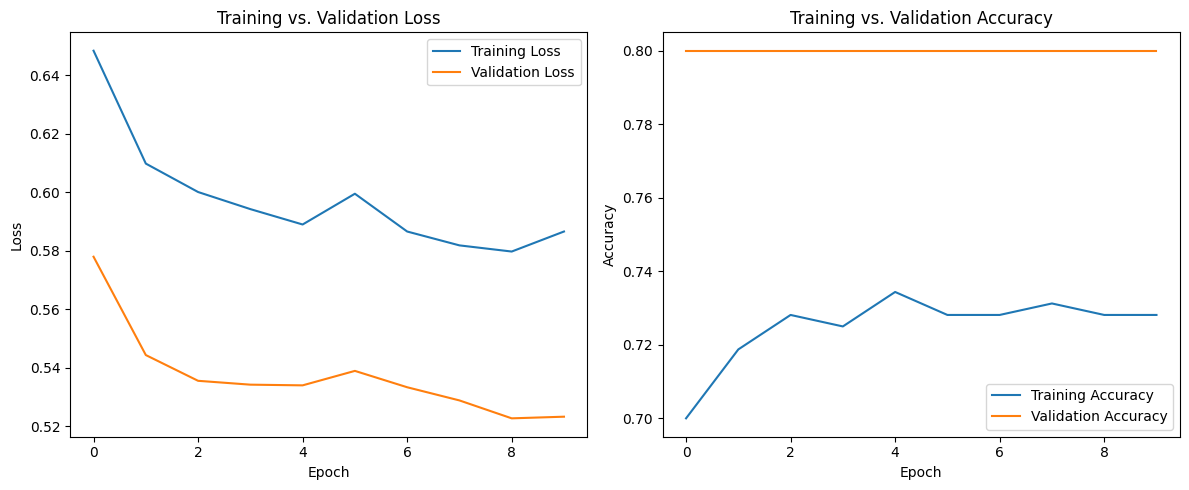

In [41]:
# Extract training history
history_dict_EEG = history_EEG.history

# Plot training & validation loss
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history_dict_EEG['loss'], label='Training Loss')
plt.plot(history_dict_EEG['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs. Validation Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history_dict_EEG['accuracy'], label='Training Accuracy')
plt.plot(history_dict_EEG['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs. Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## 06. General ML Models (Random Forest):

In [42]:
MEFAR_MID.head()

,BVP,EDA,TEMP,AccX,AccY,AccZ,HR,Delta,Theta,Alpha1,Alpha2,Beta1,Beta2,Gamma1,Gamma2,Attention,Meditation,class
0,-0.150426,0.026215,0.778824,-0.325490,0.019608,0.388235,0.357959,0.019138,0.082949,0.017362,0.020516,0.001465,0.002844,0.021253,0.044376,0.484848,0.090909,1.0
1,-0.145506,0.026215,0.778824,-0.333333,-0.003922,0.388235,0.357959,0.019138,0.082949,0.017362,0.020516,0.001465,0.002844,0.021253,0.044376,0.484848,0.090909,1.0
2,-0.135576,0.026215,0.778824,-0.349020,-0.035294,0.333333,0.357959,0.019138,0.082949,0.017362,0.020516,0.001465,0.002844,0.021253,0.044376,0.484848,0.090909,1.0
3,-0.121047,0.026215,0.778824,-0.380392,-0.027451,0.356863,0.357959,0.019138,0.082949,0.017362,0.020516,0.001465,0.002844,0.021253,0.044376,0.484848,0.090909,1.0
4,-0.103369,0.026215,0.778824,-0.411765,-0.011765,0.411765,0.357959,0.019138,0.082949,0.017362,0.020516,0.001465,0.002844,0.021253,0.044376,0.484848,0.090909,1.0


In [43]:
X_EEG.duplicated().sum()

np.int64(897220)

In [44]:
X_EEG.head()

,Delta,Theta,Alpha1,Alpha2,Beta1,Beta2,Gamma1,Gamma2,Attention,Meditation
0,0.019138,0.082949,0.017362,0.020516,0.001465,0.002844,0.021253,0.044376,0.484848,0.090909
1,0.019138,0.082949,0.017362,0.020516,0.001465,0.002844,0.021253,0.044376,0.484848,0.090909
2,0.019138,0.082949,0.017362,0.020516,0.001465,0.002844,0.021253,0.044376,0.484848,0.090909
3,0.019138,0.082949,0.017362,0.020516,0.001465,0.002844,0.021253,0.044376,0.484848,0.090909
4,0.019138,0.082949,0.017362,0.020516,0.001465,0.002844,0.021253,0.044376,0.484848,0.090909


In [45]:
# Train/Test split sample set dataframe containing EEG features:
X_train, X_test, y_train, y_test = train_test_split(X_EEG,y_all,test_size=0.2,random_state=42)

In [46]:
y_all.value_counts(normalize=True)

class
1.0    0.5
0.0    0.5
Name: proportion, dtype: float64

In [47]:
clf = RandomForestClassifier(n_estimators=50, max_depth=10, n_jobs=-1, random_state=42)
clf.fit(X_train, y_train)

,n_estimators,50
,criterion,'gini'
,max_depth,10
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [48]:
y_pred_RF = clf.predict(X_test)
y_pred_RF

array([1., 1., 0., ..., 0., 0., 0.])

In [49]:
print(classification_report(y_test,y_pred_RF))

              precision    recall  f1-score   support

         0.0       0.76      0.91      0.83     92491
         1.0       0.89      0.71      0.79     92169

    accuracy                           0.81    184660
   macro avg       0.82      0.81      0.81    184660
weighted avg       0.82      0.81      0.81    184660



In [50]:
("Accuracy:", accuracy_score(y_test, y_pred_RF))

('Accuracy:', 0.8101862883136576)

* We have slight class imbalance and it will help to set the class weight to 'balanced' 

In [51]:
clf2 = RandomForestClassifier(n_estimators=100, max_depth=20, n_jobs=-1, random_state=42, class_weight='balanced')
clf2.fit(X_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,20
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [52]:
y_pred_RF2 = clf2.predict(X_test)
y_pred_RF2

array([1., 1., 1., ..., 0., 0., 0.])

In [53]:
print(classification_report(y_test,y_pred_RF2))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     92491
         1.0       1.00      1.00      1.00     92169

    accuracy                           1.00    184660
   macro avg       1.00      1.00      1.00    184660
weighted avg       1.00      1.00      1.00    184660



In [54]:
("Accuracy:", accuracy_score(y_test, y_pred_RF2))

('Accuracy:', 0.9999025235568071)

In [55]:
# Cross validate:
scores = cross_val_score(clf2,X_EEG, y_all, cv=5)
print(f"Mean accuracy: {scores.mean():.3f} ± {scores.std():.3f}")

Mean accuracy: 0.649 ± 0.043


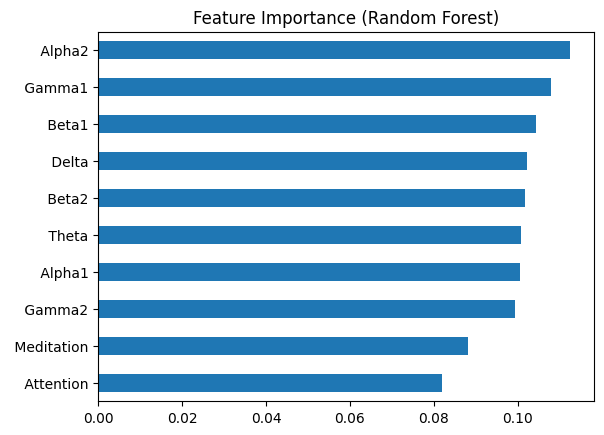

In [56]:
clf2.fit(X_train, y_train)
pd.Series(clf2.feature_importances_, index=X_EEG.columns).sort_values().plot.barh()
plt.title("Feature Importance (Random Forest)")
plt.show()

## 07. General ML Models (XGBoost):

*XGBoost Extreme Gradient Boosting - ensemble tree-based method, builds tree's sequentially, each one learning from the errors of the previous one. Each tree corrects its predecessor.*

In [57]:
# Train-test split
X_train_XGBoost, X_test_XGBoost, y_train_XGBoost, y_test_XGBoost = train_test_split(X_EEG, y_all, test_size=0.2, random_state=42)

# XGBoost model
model_XGB = XGBClassifier(n_estimators=100, max_depth=6, use_label_encoder=False, eval_metric='logloss')
model_XGB.fit(X_train_XGBoost, y_train_XGBoost)

# Evaluation
y_pred_XGB = model_XGB.predict(X_test_XGBoost)
print(classification_report(y_test_XGBoost, y_pred_XGB))

/Users/timoturnley/.pyenv/versions/3.10.6/envs/Neurocheck/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [07:42:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


              precision    recall  f1-score   support

         0.0       0.84      0.86      0.85     92491
         1.0       0.86      0.83      0.85     92169

    accuracy                           0.85    184660
   macro avg       0.85      0.85      0.85    184660
weighted avg       0.85      0.85      0.85    184660



* The model is well balanced across both classes. 
* Results are generalizable and indicate the EEG features are informative. 


In [58]:
# Improving model performance.
xgb_model = XGBClassifier(
    n_estimators=100,            # Number of trees (boosting rounds). More trees can increase performance but risk overfitting.
    max_depth=6,                 # Maximum depth of each tree. Controls model complexity. Deeper trees can capture more patterns but may overfit.
    learning_rate=0.1,           # Shrinks the contribution of each tree. Lower values make learning slower but can yield better generalization.
    subsample=0.8,               # Fraction of training instances used per tree. Helps prevent overfitting by adding randomness.
    colsample_bytree=0.8,        # Fraction of features used per tree. Reduces correlation between trees and improves generalization.
    use_label_encoder=False,     # Disables legacy label encoder, recommended in recent versions of XGBoost (avoids warning).
    eval_metric='logloss',       # Evaluation metric for binary classification. 'logloss' is appropriate for probabilistic outputs.
    random_state=42              # Ensures reproducibility of results by fixing the random seed.
)

In [59]:
# fit the updated XGBoost model
xgb_model.fit(X_train_XGBoost, y_train_XGBoost)

# Evaluation
y_pred_XGB2 = xgb_model.predict(X_test_XGBoost)
print(classification_report(y_test_XGBoost, y_pred_XGB2))

/Users/timoturnley/.pyenv/versions/3.10.6/envs/Neurocheck/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [07:42:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


              precision    recall  f1-score   support

         0.0       0.74      0.80      0.77     92491
         1.0       0.78      0.72      0.75     92169

    accuracy                           0.76    184660
   macro avg       0.76      0.76      0.76    184660
weighted avg       0.76      0.76      0.76    184660



## 08. 1D CNN Model (EEG Features Only):

In [60]:
# Define sampling and windowing parameters
sampling_rate = 32                     # MEFAR data has 32 samples per second
window_seconds = 10                    # Each window covers 10 seconds
window_size = sampling_rate * window_seconds  # 320 samples per window
stride = int(window_size * 0.5)        # 50% overlap between windows → 5s step

# Lists to store results
X_windows_EEG, y_windows_EEG, session_ids = [], [], []

# Loop through each session defined in session_map
for _, row in session_map.iterrows():
    session_id = row['session_id']               # Session identifier
    start = int(row['start_index'])              # Start index of session in full dataset
    end = int(row['end_index'])                  # End index of session

    # Extract the features and labels for this session
    X_session_EEG = X_EEG.iloc[start:end].values         # Shape: (session_length, num_features)
    y_session_EEG = y_all.iloc[start:end].values         # Shape: (session_length,)

    # Slide window through session using defined stride
    for i in range(0, len(X_session_EEG) - window_size + 1, stride):
        # Extract the feature window and corresponding label window
        window_EEG = X_session_EEG[i:i + window_size]          # Shape: (320, num_features)
        label_window_EEG = y_session_EEG[i:i + window_size]    # Shape: (320,)

        # ✅ Assign label based on majority vote in the 10s window
        # If more than 50% of samples in the window are "1" (fatigued), label the window as fatigued
        majority_label = int(label_window_EEG.mean() > 0.5)

        # Store results
        X_windows_EEG.append(window_EEG)
        y_windows_EEG.append(majority_label)
        session_ids.append(session_id)

# Convert lists to numpy arrays for modeling
X_windows_EEG = np.array(X_windows_EEG)       # Shape: (num_windows, 320, num_features)
y_windows_EEG = np.array(y_windows_EEG)       # Shape: (num_windows,)
session_ids = np.array(session_ids)   # Shape: (num_windows,)

In [61]:
# MODEL VERSION 001
model_CNN = Sequential([
    # Conv layer to detect short-term patterns (5 time steps)
    Conv1D(filters=64, kernel_size=5, activation='relu', input_shape=(320, 10)),
    MaxPooling1D(pool_size=2),  # Downsample

    # Second Conv layer to go deeper
    Conv1D(filters=128, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),

    # Global pooling to reduce each feature map to a single number
    GlobalAveragePooling1D(),

    # Fully connected layer
    Dense(32, activation='relu'),
    Dropout(0.4),

    # Output
    Dense(1, activation='sigmoid')  # Binary classification
])


/Users/timoturnley/.pyenv/versions/3.10.6/envs/Neurocheck/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [62]:
# Create train-test split (e.g., 80% train, 20% test)
X_train_EEG, X_test_EEG, y_train_EEG, y_test_EEG = train_test_split(
    X_windows_EEG, y_windows_EEG,
    test_size=0.2,
    random_state=42,
    stratify=y_windows_EEG  # ensures same class distribution in train and test
)

In [63]:
import tensorflow as tf
from tensorflow.keras import backend as K

def focal_loss(gamma=2., alpha=0.25):
    def loss_fn(y_true, y_pred):
        y_true = K.cast(y_true, tf.float32)
        bce = K.binary_crossentropy(y_true, y_pred)
        pt = y_true * y_pred + (1 - y_true) * (1 - y_pred)
        loss = alpha * K.pow(1. - pt, gamma) * bce
        return loss
    return loss_fn

In [64]:
model_CNN.compile(optimizer='adam',
                  loss = focal_loss(gamma=2.,alpha=0.75),
                  metrics=['accuracy'])

In [65]:
history_CNN = model_CNN.fit(X_train_EEG, y_train_EEG, validation_split=0.2, epochs=10, batch_size=32)

Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.6098 - loss: 0.1238 - val_accuracy: 0.8000 - val_loss: 0.0947
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7268 - loss: 0.1153 - val_accuracy: 0.8000 - val_loss: 0.0979
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7209 - loss: 0.1135 - val_accuracy: 0.8000 - val_loss: 0.1007
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7341 - loss: 0.1125 - val_accuracy: 0.8000 - val_loss: 0.0954
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7530 - loss: 0.1067 - val_accuracy: 0.8000 - val_loss: 0.0966
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7163 - loss: 0.1131 - val_accuracy: 0.8000 - val_loss: 0.0986
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7364 - loss: 0.1094 - val_accuracy: 0.8000 - val_loss: 0.0928
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7526 - loss: 0.1057 - val_accuracy: 0.8000 - val_loss

In [66]:
y_pred = (model_EEG.predict(X_test_EEG) > 0.5).astype(int)
print(classification_report(y_test_EEG, y_pred))

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
              precision    recall  f1-score   support

           0       0.80      0.84      0.82        75
           1       0.45      0.38      0.42        26

    accuracy                           0.72       101
   macro avg       0.63      0.61      0.62       101
weighted avg       0.71      0.72      0.71       101



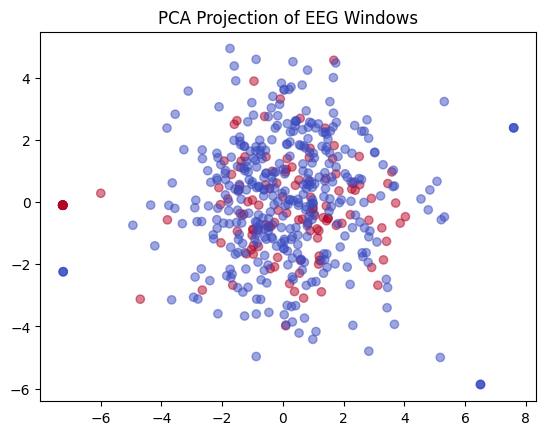

In [67]:
from sklearn.decomposition import PCA
X_flat = X_windows_EEG.reshape(X_windows_EEG.shape[0], -1)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_flat)

import matplotlib.pyplot as plt
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_windows_EEG, cmap='coolwarm', alpha=0.5)
plt.title("PCA Projection of EEG Windows")
plt.show()

## 09: Back to the Drawing Borad:

In [69]:
# Aggregate functions applied to each feature per window
def extract_stats_per_window(X):
    features = []
    for window in X:
        f_mean = window.mean(axis=0)
        f_std = window.std(axis=0)
        f_min = window.min(axis=0)
        f_max = window.max(axis=0)
        features.append(np.concatenate([f_mean, f_std, f_min, f_max]))
    return np.array(features)

X_features = extract_stats_per_window(X_windows_EEG)

In [70]:
X_features.shape

(501, 40)

In [71]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.76      1.00      0.87        94
           1       1.00      0.09      0.17        32

    accuracy                           0.77       126
   macro avg       0.88      0.55      0.52       126
weighted avg       0.82      0.77      0.69       126



In [72]:
from sklearn.metrics import precision_recall_curve, classification_report

# Get predicted probabilities
y_scores = rf.predict_proba(X_test)[:, 1]

# Lower threshold (try 0.3)
y_pred_custom = (y_scores > 0.3).astype(int)

# New metrics
print(classification_report(y_test, y_pred_custom))

              precision    recall  f1-score   support

           0       0.77      0.81      0.79        94
           1       0.33      0.28      0.31        32

    accuracy                           0.67       126
   macro avg       0.55      0.54      0.55       126
weighted avg       0.66      0.67      0.67       126



In [73]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, precision_recall_curve

# Train on statistical features
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(X_train, y_train)

# Predict probabilities
y_scores = xgb.predict_proba(X_test)[:, 1]

# Custom threshold (start with 0.3)
y_pred_custom = (y_scores > 0.3).astype(int)

# Report
print(classification_report(y_test, y_pred_custom))

/Users/timoturnley/.pyenv/versions/3.10.6/envs/Neurocheck/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [07:44:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


              precision    recall  f1-score   support

           0       0.76      0.85      0.80        94
           1       0.33      0.22      0.26        32

    accuracy                           0.69       126
   macro avg       0.55      0.53      0.53       126
weighted avg       0.65      0.69      0.67       126



In [74]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

In [75]:
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42, verbosity=0)

grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring='f1',  # prioritize balanced class performance
    cv=3,
    verbose=1,
    n_jobs=1
)

grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 72 candidates, totalling 216 fits


,estimator,"XGBClassifier...ree=None, ...)"
,param_grid,"{'colsample_bytree': [0.8, 1.0], 'learning_rate': [0.01, 0.1, ...], 'max_depth': [3, 5, ...], 'n_estimators': [100, 200], ...}"
,scoring,'f1'
,n_jobs,1
,refit,True
,cv,3
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,objective,'binary:logistic'


In [76]:
X_EEG.shape

(923298, 10)

In [ ]:
# Create train-test split (e.g., 80% train, 20% test)
X_train_original, X_test_original, y_train_original, y_test_original = train_test_split(
    X_EEG,y_all,
    test_size=0.2,
    random_state=42,
    stratify=y_all  # ensures same class distribution in train and test
)

In [ ]:
# Train on statistical features
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(X_train_original, y_train_original)

# Predict probabilities
y_scores = xgb.predict_proba(X_test_original)[:, 1]

# Custom threshold (start with 0.3)
y_pred_custom = (y_scores > 0.3).astype(int)

# Report
print(classification_report(y_test_original, y_pred_custom))

/Users/timoturnley/.pyenv/versions/3.10.6/envs/Neurocheck/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [06:50:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


              precision    recall  f1-score   support

         0.0       0.99      0.33      0.49     92330
         1.0       0.60      1.00      0.75     92330

    accuracy                           0.66    184660
   macro avg       0.80      0.66      0.62    184660
weighted avg       0.80      0.66      0.62    184660



In [ ]:
from sklearn.metrics import f1_score
import numpy as np

thresholds = np.arange(0.1, 0.9, 0.05)
best_thresh, best_f1 = 0.5, 0

for t in thresholds:
    preds = (y_scores > t).astype(int)
    f1 = f1_score(y_test_original, preds)
    if f1 > best_f1:
        best_f1 = f1
        best_thresh = t

print(f"Best threshold: {best_thresh:.2f} → F1: {best_f1:.3f}")

Best threshold: 0.45 → F1: 0.847


In [ ]:
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(X_train_original, y_train_original)

# Predict probabilities
y_scores = xgb.predict_proba(X_test_original)[:, 1]

# Custom threshold (start with 0.45)
y_pred_custom = (y_scores > 0.45).astype(int)

# Report
print(classification_report(y_test_original, y_pred_custom))

/Users/timoturnley/.pyenv/versions/3.10.6/envs/Neurocheck/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [06:53:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


              precision    recall  f1-score   support

         0.0       0.91      0.74      0.81     92330
         1.0       0.78      0.93      0.85     92330

    accuracy                           0.83    184660
   macro avg       0.84      0.83      0.83    184660
weighted avg       0.84      0.83      0.83    184660



* Class 0 - Non Fatigued = very high precision, few false positivies.
* Class 1 - Fatigued = very high recall, capturing almost all fatigue cases. 
* F1 Scores above 0.80 for both - harmonic balance of precision and recall. 
* 83% accuracy - reliable and stable. 
* Model is slighly more aggressive in flagging fatigue (class 1) which is good for safety-critical tasks.